<a href="https://colab.research.google.com/github/cfong32/netflix-prize/blob/main/step3_gradient_descent_M500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# download preprocessed dataset
!wget -qO ratings_M50-MF10.dfpkl https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/ERH77foX8FJHmpPoczPf4-UBxHLwVZh-qobnU9uQvGuguw?download=1
!wget -qO ratings_M500-MF10.dfpkl https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/EY94E7t0oQ9Hs5ChnFwFVMQB6PqKrwdvejzDkteFooAbSg?download=1

In [4]:
import torch
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
pd.set_option('display.min_rows', 4)

In [5]:
# read dataset into dataframe

df = (pd.read_pickle('ratings_M500-MF10.dfpkl')
      .assign(target=lambda x: x.rating/6)
)
N = df.user.nunique()
M = df.movie.nunique()

print('num_user:', N, 'num_movie:', M)
display(df)

num_user: 96534 num_movie: 500


,user,movie,rating,target
0,0,0,3.0,0.500000
1,0,7,4.0,0.666667
...,...,...,...,...
1830281,96533,481,4.0,0.666667
1830282,96533,493,4.0,0.666667


In [6]:
# split data into train and test sets

split = 0.8
train = df.sample(frac=split)
test  = df[~df.index.isin(train.index)]

display(train)
display(test)

,user,movie,rating,target
571607,23002,78,5.0,0.833333
600006,24181,437,1.0,0.166667
...,...,...,...,...
719935,29987,222,5.0,0.833333
1297747,61877,360,3.0,0.500000


,user,movie,rating,target
1,0,7,4.0,0.666667
3,0,29,3.0,0.500000
...,...,...,...,...
1830270,96532,451,3.0,0.500000
1830277,96533,358,3.0,0.500000


In [7]:
# build the matrix-multiplication-based model

class UV(nn.Module):
    def __init__(self, N, M, D):                # N: num_user, M: num_movie, D: embedding dimension
        super().__init__()
        self.U = nn.Embedding(N, D)             # matrix U, user embeddings, sized N-by-D
        self.V = nn.Embedding(M, D)             # matrix V, movie embeddings, sized M-by-D
        
    def forward(self, u_idx, m_idx):
        U = self.U(u_idx)                       # retrieve user embeddings by user indexes
        V = self.V(m_idx)                       # retrieve movie embeddings by movie indexes
        dot_products = (U*V).sum(dim=1)         # predicted ratings are their dot products
        output = torch.sigmoid(dot_products)    # map to [0,1]
        return output

In [21]:
###
# training
###

# check GPU
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# set hyperparameters
D = 10              # embedding dimension
lr = 1e-3           # learning rate
batch_size = 1_000_000
max_epoch = 10_000
patience = 10       # early stop if not improving in this num of evaluations

# initialize model and ...
model = UV(N, M, D).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# convert data to torch Tensor
train_u_idx = torch.IntTensor  (train.user.values).to(device)
train_v_idx = torch.IntTensor  (train.movie.values).to(device)
train_y     = torch.FloatTensor(train.target.values).to(device)
train_size  = len(train_u_idx)

test_u_idx  = torch.IntTensor  (test.user.values).to(device)
test_v_idx  = torch.IntTensor  (test.movie.values).to(device)
test_y      = torch.FloatTensor(test.target.values).to(device)

# train
recs = []
min_test_loss = None
for epoch in range(max_epoch):

    # gradient descent
    model.train()
    optimizer.zero_grad()

    batch_idx = torch.randperm(train_size)[:batch_size]
    train_y_hat = model(train_u_idx[batch_idx], train_v_idx[batch_idx])
    loss = loss_fn(train_y_hat, train_y[batch_idx])
    loss.backward()
    optimizer.step()

    # evaluate test loss
    if epoch % 100 == 0:
        model.eval()
        test_y_hat = model(test_u_idx, test_v_idx)
        test_loss = loss_fn(test_y_hat, test_y).item()
        rec = {
            'epoch'     : epoch,
            'train_loss': loss.item(),
            'test_loss' : test_loss,
        }
        recs.append(rec)
        print(rec)

        # check for early stopping
        if min_test_loss is None or test_loss < min_test_loss:
            min_test_loss = test_loss
            not_improving_count = 0
        else:
            not_improving_count += 1
            if not_improving_count >= patience:
                break

{'epoch': 0, 'train_loss': 0.17787280678749084, 'test_loss': 0.17809328436851501}
{'epoch': 100, 'train_loss': 0.15688101947307587, 'test_loss': 0.16757109761238098}
{'epoch': 200, 'train_loss': 0.13699133694171906, 'test_loss': 0.1562931090593338}
{'epoch': 300, 'train_loss': 0.11886447668075562, 'test_loss': 0.1444433480501175}
{'epoch': 400, 'train_loss': 0.10210087150335312, 'test_loss': 0.1323365420103073}
{'epoch': 500, 'train_loss': 0.08770862221717834, 'test_loss': 0.12034118175506592}
{'epoch': 600, 'train_loss': 0.07511317729949951, 'test_loss': 0.10880787670612335}
{'epoch': 700, 'train_loss': 0.06442016363143921, 'test_loss': 0.09804236888885498}
{'epoch': 800, 'train_loss': 0.05534520372748375, 'test_loss': 0.0882200226187706}
{'epoch': 900, 'train_loss': 0.047888852655887604, 'test_loss': 0.07941526919603348}
{'epoch': 1000, 'train_loss': 0.041592277586460114, 'test_loss': 0.07161452621221542}
{'epoch': 1100, 'train_loss': 0.036480195820331573, 'test_loss': 0.064783208072

<Axes: xlabel='epoch'>

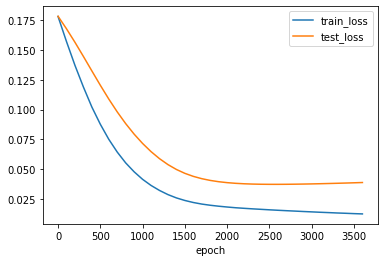

In [22]:
# training curves
pd.DataFrame(recs).set_index('epoch')[['train_loss', 'test_loss']].plot()

In [23]:
# resulted U and V
U = model.U.weight
V = model.V.weight

print('first few rows of,')
print('U:', U[:3])
print('V:', V[:3])

first few rows of,
U: tensor([[ 0.0730,  0.0471, -0.0196,  0.3821,  0.3350,  0.3392, -0.5862,  0.7058,
          0.0784, -0.0588],
        [-0.4369, -0.1502, -0.4918, -0.8183,  0.5230, -0.7990,  0.1755,  0.0119,
          0.0954, -0.5365],
        [-0.5355,  0.5368, -0.3722,  0.2710, -0.2666, -0.1509, -0.3008,  0.6377,
          0.9970,  0.5200]], device='cuda:0', grad_fn=<SliceBackward0>)
V: tensor([[-0.5047,  0.5009, -0.3206,  0.2988,  0.5347, -0.3281, -0.5756,  0.0259,
          0.2015, -0.9496],
        [ 0.6533, -0.0198,  0.7832, -1.1955,  0.5874, -0.0174, -0.2158, -0.2643,
          0.4091, -0.8089],
        [-0.5783, -0.1425,  0.1198, -0.3273,  0.2912, -0.2969, -0.7975, -0.4315,
          0.2627, -0.8581]], device='cuda:0', grad_fn=<SliceBackward0>)


In [24]:
# prediction results

test_y_hat = model(test_u_idx, test_v_idx).cpu().detach().numpy()

df_res = (
    test
    .assign(target_pred    =test_y_hat,
            rating_pred    =lambda x: (x.target_pred*6).clip(1,5),  # clipped between 1 and 5
            rating_residual=lambda x: x.rating - x.rating_pred)
)

df_res.sample(10)

,user,movie,rating,target,target_pred,rating_pred,rating_residual
1598903,80177,421,2.0,0.333333,0.464271,2.785623,-0.785623
231660,9495,240,4.0,0.666667,0.587173,3.523041,0.476959
1734475,89075,328,3.0,0.500000,0.627561,3.765367,-0.765367
1505631,74597,29,2.0,0.333333,0.781184,4.687104,-2.687104
1668194,84480,310,4.0,0.666667,0.664965,3.989790,0.010210
1384556,67200,412,3.0,0.500000,0.744020,4.464121,-1.464121
517151,20842,261,3.0,0.500000,0.638651,3.831905,-0.831905
1264284,59813,190,4.0,0.666667,0.633747,3.802479,0.197521
1161449,53555,256,5.0,0.833333,0.858962,5.000000,0.000000
1134454,51910,412,3.0,0.500000,0.522995,3.137971,-0.137971


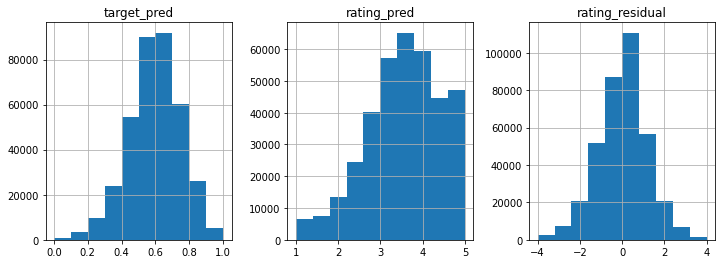

In [25]:
# distribution of residuals
df_res[['target_pred', 'rating_pred', 'rating_residual']].hist(figsize=(12,4), layout=(1,3))
plt.show()